In [1]:
import numpy as np
import matplotlib.pyplot as plt

data    = np.genfromtxt("data-nonlinear.txt", delimiter=',')

class Model:
    def __init__(self):
        self.weight = np.zeros(16)
        self.bias = np.zeros(1)
        
    def __call__(self, x: np.ndarray):
        x = (self.weight * x).sum(axis=1, keepdims=True) + self.bias
        x = 1 / (1 + np.exp(-x)) 
        return x
    
    def __str__(self):
        return f'{self.weight}'

def BCELoss(pred: np.ndarray, label: np.ndarray):
    return -(label * np.log(pred) + (1 - label) * np.log(1 - pred)).mean(dtype=np.float64)

class LearningRate:
    def __init__(self, lr=1e-2, step=0):
        self._lr = lr
        self._step = step
    
    def item(self):
        return self._lr
    
    def step(self):
        self._step += 1

In [2]:
x_train = data[:, 0:2]
y_train = data[:, 2:3]

transformed_data = x_train
for i in range(2, 7):
    transformed_data = np.concatenate((transformed_data, x_train ** i), axis=1)

    
for i in range(2):
    for j in range(2):
        transformed_data = np.concatenate((transformed_data, x_train[:, 0:1] ** i * x_train[:, 1:2] ** j), axis=1)

transformed_data.shape

(118, 16)

In [3]:
from tqdm import tqdm

learning_rate = LearningRate()

model = Model()

losses = []
accuracys = []
weights = []
biases = []
epoch = 1000000
e = 1e-20

for step in tqdm(range(epoch)):
    # BCELoss
    loss: np.ndarray = BCELoss(model(transformed_data), y_train)
    preds = model(transformed_data) > 0.5
    acc = (preds == y_train).sum() / y_train.shape[0]
    
    # Save losses and parameters
    losses += [loss.tolist()]
    weights += [model.weight.tolist()]
    biases += [model.bias.tolist()]
    accuracys += [acc.item()]
    
    # Compute Error
    error = model(transformed_data) - y_train
    
    # Gradient Descent Algorithm
    temp_bias = model.bias - learning_rate.item() * error.mean()
    temp_weight = model.weight - learning_rate.item() * (error * transformed_data).mean(axis=0)
    
    # Update parameter
    model.bias = temp_bias
    model.weight = temp_weight

losses = np.asarray(losses)
weights = np.asarray(weights)
biases = np.asarray(biases)

print(f'Train step is {step}')
print(f'The optimal linear model is {model}')
print(f'Train loss: {loss:.4f}')
print(f'Train accuracy: {acc * 100:f}')

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:38<00:00, 10203.76it/s]


Train step is 999999
The optimal linear model is [ 1.07657559  2.64073672 -7.14631673 -9.01447444  4.21472792 -4.75185505
 -5.21239149 -4.85765229 -1.07801898  3.51357301 -6.35122887  2.56330186
  2.25897411  2.64073672  1.07657559 -7.15366541]
Train loss: 0.3311
Train accuracy: 86.440678


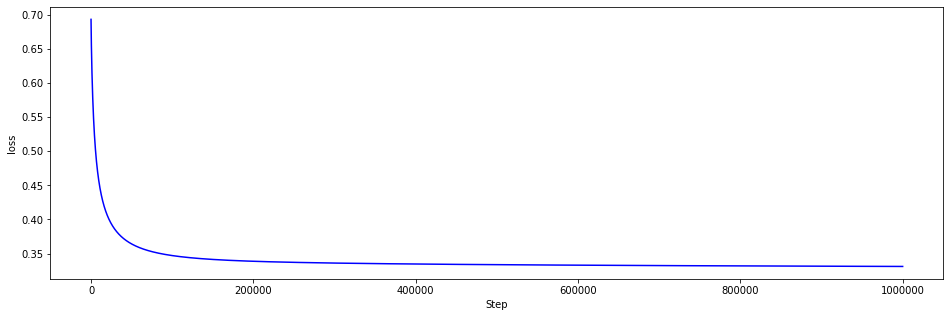

In [4]:
plt.figure(figsize=(16, 5))
plt.plot(losses, c='b')
plt.ylabel('loss')
plt.xlabel('Step')
plt.show()

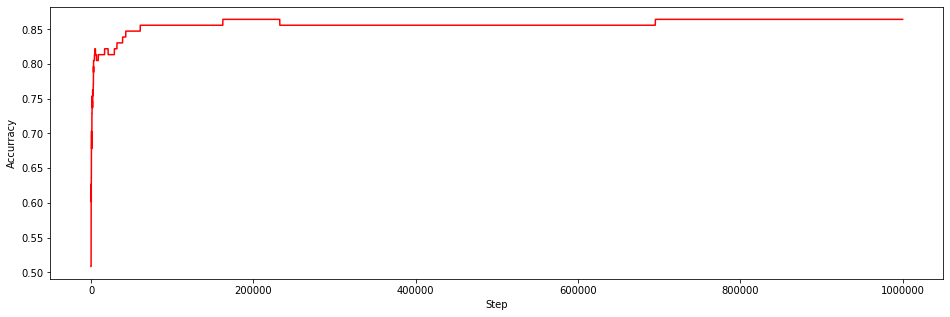

In [5]:
plt.figure(figsize=(16, 5))
plt.plot(accuracys, c='r')
plt.ylabel('Accurracy')
plt.xlabel('Step')
plt.show()